# Setup

### Imports

In [1]:
# Standard
import math

# Pandas and plotting
import pandas as pd
import numpy as np
from plotnine import *

# SK Learn requirements
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer



import warnings
warnings.filterwarnings('ignore')

C:\Users\blamarre\AppData\Local\Continuum\anaconda3\envs\MercariKeeggle\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load Data

In [3]:
import os

train_path = os.getcwd() + "\\data\\train.tsv"
train = pd.read_csv(train_path, sep='\t')

# Set random seed for reproducibility
pd.np.random.seed(369)

# Preprocessing
## Parse out individual category levels
Product category names consist of subcategory trees (Men/Tops/T-shirts). There don't appear to be more than 5 levels and the vast majority of them have just 3 levels. Below, we create a variable for each level.

In [16]:
from sklearn import preprocessing

train_x = train[["brand_name", "shipping", "category_name"]]
train_y = train.price

def piece(string, delim, n):
    string = str(string)
    if string.count(delim) < n:
        return pd.np.NaN
    return string.split(delim)[n]

train_x["category1"] = train_x.category_name.map(lambda x: piece(x, "/", 0))
train_x["category2"] = train_x.category_name.map(lambda x: piece(x, "/", 1))
train_x["category3"] = train_x.category_name.map(lambda x: piece(x, "/", 2))
train_x["category4"] = train_x.category_name.map(lambda x: piece(x, "/", 3))
train_x["category5"] = train_x.category_name.map(lambda x: piece(x, "/", 4))
train_x = train_x.drop(columns='category_name')
train_x.head()

,brand_name,shipping,category1,category2,category3,category4,category5
0,NaN,1,Men,Tops,T-shirts,NaN,NaN
1,Razer,0,Electronics,Computers & Tablets,Components & Parts,NaN,NaN
2,Target,1,Women,Tops & Blouses,Blouse,NaN,NaN
3,NaN,1,Home,Home Décor,Home Décor Accents,NaN,NaN
4,NaN,0,Women,Jewelry,Necklaces,NaN,NaN


## Fill in missing data

For now we will be representing any missing data with the string 'zMissing.'

In [17]:
train_x = train_x.fillna('zMissing')
train_x.head()

,brand_name,shipping,category1,category2,category3,category4,category5
0,zMissing,1,Men,Tops,T-shirts,zMissing,zMissing
1,Razer,0,Electronics,Computers & Tablets,Components & Parts,zMissing,zMissing
2,Target,1,Women,Tops & Blouses,Blouse,zMissing,zMissing
3,zMissing,1,Home,Home Décor,Home Décor Accents,zMissing,zMissing
4,zMissing,0,Women,Jewelry,Necklaces,zMissing,zMissing


## Organize item_description

In [4]:
train["item_description"]=train["item_description"].astype(str)
descr_corpus = list(train["item_description"])

## Create item_description sparse feature matrix

In [6]:
vectorizer = CountVectorizer()

Y = vectorizer.fit_transform(descr_corpus)

In [7]:
#We now have a spare feature matrix
sparse_matrix = Y.toarray()
tokens = vectorizer.get_feature_names()

MemoryError: 

# One hot encode
http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features

Create dummy variables out of categorical variables. First we use LabelEncoder to swap out category names with numbers. Then we use OneHotEncoder to pivot out those values in to columns.

**OneHotEncoder**

* Encode categorical integer features using a one-hot aka one-of-K scheme.
* The input to this transformer should be a matrix of integers, denoting the values taken on by categorical (discrete) features.
* The output will be a sparse matrix where each column corresponds to one possible value of one feature.
* It is assumed that input features take on values in the range [0, n_values).
* This encoding is needed for feeding categorical data to many scikit-learn estimators, notably linear models and SVMs with the standard kernels.



In [18]:
# Pandas is proving to be too slow
# dummies = pd.get_dummies(train_x)
# lets try it with sklearn
encoder = preprocessing.OneHotEncoder()
label_encoder = preprocessing.LabelEncoder()
data_label_encoded = train_x.apply(label_encoder.fit_transform)
train_x_encoded = encoder.fit_transform(data_label_encoded)

# Supervised Learning

Lets start by experimenting with a simple SGD regressor becasue of how fast it is.
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor

Further down the line we should incorporate matrix factorization as the collinearity and correlations are likely quite high. We'll also want to perform cross validation to pick optimal parameters for SGD.

In [19]:
# This competition uses root mean squared log error.
# Lets use this to evaluate our models as well.
from sklearn.metrics import make_scorer

# vectorized error calc
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

rmsle_score = make_scorer(rmsle, greater_is_better=False)

## Stochastic Gradient Descent - SGD
Stochastic gradient descent is a simple yet very efficient approach to fit linear models. It is particularly useful when the number of samples (and the number of features) is very large. The partial_fit method allows only/out-of-core learning. The classes SGDClassifier and SGDRegressor provide functionality to fit linear models for classification and regression using different (convex) loss functions and different penalties.

### Grid Search
SGD has a lot of parameters that need to be optimized. Lets try a 10-fold-cross-validation on several potential values and figure out whats giving us the best rmsle.

In [7]:
param_grid = [
  {'loss': ["squared_loss", "huber", "epsilon_insensitive"], 
   'penalty': ['elasticnet'],
   'alpha' : 10.0**-pd.np.arange(1,7),
   'l1_ratio' : [0, .15, .3, .5, .75, 1],
   'learning_rate' : ['constant', 'optimal', 'invscaling']
  }
 ]
sgd_cv = GridSearchCV(estimator=SGDRegressor(), param_grid=param_grid, cv=5, scoring=rmsle_score)
sgd_cv.fit(train_x_encoded, train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'loss': ['squared_loss', 'huber', 'epsilon_insensitive'], 'penalty': ['elasticnet'], 'alpha': array([  1.00000e-01,   1.00000e-02,   1.00000e-03,   1.00000e-04,
         1.00000e-05,   1.00000e-06]), 'l1_ratio': [0, 0.15, 0.3, 0.5, 0.75, 1], 'learning_rate': ['constant', 'optimal', 'invscaling']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmsle, greater_is_better=False), verbose=0)

In [9]:
sgd_cv.best_estimator_

SGDRegressor(alpha=1.0000000000000001e-05, average=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=1, learning_rate='optimal',
       loss='epsilon_insensitive', max_iter=None, n_iter=None,
       penalty='elasticnet', power_t=0.25, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False)

### Optimal SGD
We have found our optimal parameters. Lets use them on the whole data set and see how we're doing.

In [23]:
sgd = SGDRegressor(alpha=1.0000000000000001e-05, average=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=1, learning_rate='optimal',
       loss='epsilon_insensitive', max_iter=None, n_iter=None,
       penalty='elasticnet', power_t=0.25, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False)
scores = cross_val_score(sgd, train_x_encoded, train_y, cv=10, scoring=rmsle_score)

In [34]:
scores = np.vectorize(abs)(scores)
print("Average CV performance: {0}".format(scores.mean()))

Average CV performance: 0.5992143265093107


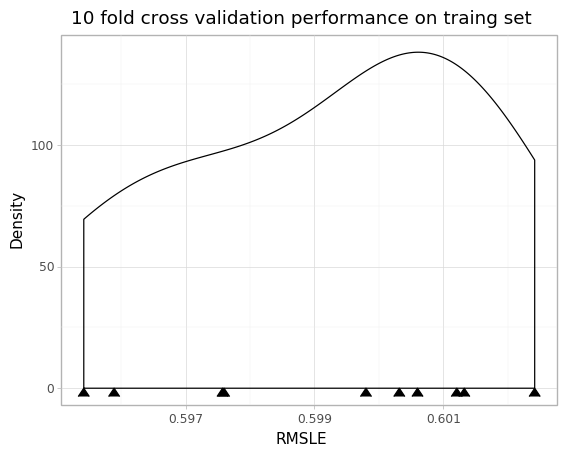

<ggplot: (103783198563)>

In [61]:
ggplot(pd.DataFrame({'scores': scores}), aes('scores')) + \
    geom_density() + geom_point(aes(x="scores", y=0), shape=6, size=4) + \
    ggtitle("10 fold cross validation performance on traing set") + \
    ylab("Density") + xlab("RMSLE") + \
    theme_light()